In [1]:
import numpy as np
import pandas as pd
import os
for dirname, _, filenames in os.walk('spam_ham_dataset.csv'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
df = pd.read_csv('spam_ham_dataset.csv')
df.head()

,Unnamed: 0,label,text,label_num
0,605,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,2349,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,3624,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,4685,spam,"Subject: photoshop , windows , office . cheap ...",1
4,2030,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  5171 non-null   int64 
 1   label       5171 non-null   object
 2   text        5171 non-null   object
 3   label_num   5171 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 161.7+ KB


In [4]:
df.isna().sum()

Unnamed: 0    0
label         0
text          0
label_num     0
dtype: int64

<AxesSubplot: xlabel='label', ylabel='count'>

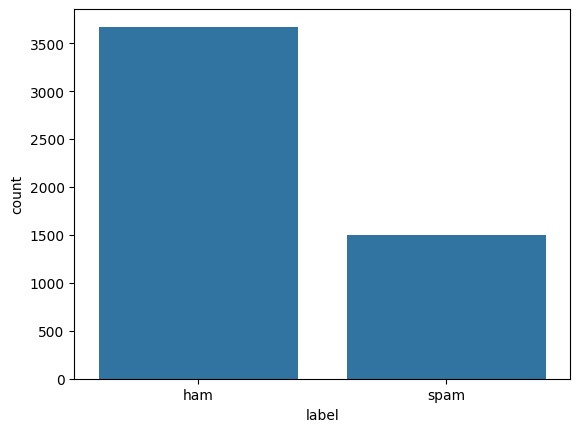

In [5]:
import seaborn as sns
sns.countplot(x="label",data=df)

# Data Cleansing

In [6]:
print(df['text'][0])

Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


In [7]:
pip install contractions

Note: you may need to restart the kernel to use updated packages.


In [8]:
import contractions
#contractions adalah paket dalam python yang digunakan untuk memperluas contractions dalam bahasa Inggris ke bentuk aslinya. Contoh I'll menjadi "Saya akan"
from tqdm import tqdm #tqdm digunakan untuk melacak kemajuan pekerjaan. Paket ini menampilkan persentase perulangan yang telah dilakukan.
import nltk
#nltk adalah sebuah paket pustaka yang terutama digunakan untuk menangani masalah yang berhubungan dengan pemrosesan bahasa alami.
import re
nltk.download('stopwords')
from nltk.corpus import stopwords
#mengunduh stopwords dari bahasa Inggris
stopwords = stopwords.words('english')
#Menghapus stopwords 'no','nor' dan 'not'
stopwords.remove('no')
stopwords.remove('nor')
stopwords.remove('not')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ela\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
processed_mails=[]
for i in tqdm(df['text']):
    #Regular expression that removes all the html tags pressent in the reviews
    i=re.sub('(<[\w\s]*/?>)',"",i)
    #Expanding all the contractions present in the review to is respective actual form
    i=contractions.fix(i)
    #Removing all the special charactesrs from the review text
    i=re.sub('[^a-zA-Z0-9\s]+',"",i)
    #Removing all the digits present in the review text
    i=re.sub('\d+',"",i)
    #Making all the review text to be of lower case as well as removing the stopwords and words of length less than 3
    processed_mails.append(" ".join([j.lower() for j in i.split() if j not in stopwords and len(j)>=3]))

 12%|█▏        | 638/5171 [00:00<00:05, 823.05it/s]

100%|██████████| 5171/5171 [00:06<00:00, 739.00it/s] 


In [10]:
#Creating a new datafram using the Processed Reviews
processed_df=pd.DataFrame({'text':processed_mails,'Spam/Ham':list(df['label_num'])})
processed_df.head()

,text,Spam/Ham
0,subject enron methanol meter follow note gave ...,0
1,subject hpl nom january see attached file hpln...,0
2,subject neon retreat around wonderful time yea...,0
3,subject photoshop windows office cheap main tr...,1
4,subject indian springs deal book teco pvr reve...,0


# Train Model

In [11]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

## **DATA PREPARASI**

In [12]:
X=processed_df['text']
Y=processed_df['Spam/Ham']
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,stratify=Y,test_size=0.2, random_state = 0)

In [13]:
# Menyimpan hasil train dan test ke dalam DataFrame
train_data = pd.DataFrame({'text': x_train, 'Spam/Ham': y_train})
test_data = pd.DataFrame({'text': x_test, 'Spam/Ham': y_test})

# Menyimpan DataFrame ke dalam file CSV
train_data.to_csv('train_data_spam_ham.csv', index=False)
test_data.to_csv('test_data_spam_ham.csv', index=False)

# **EKSTRAKSI FITUR**

In [14]:
# TF-IDF Vectorizer untuk mengubah teks menjadi representasi vektor TF-IDF
tfidf_vectorizer = TfidfVectorizer()
# Transformasi data teks menjadi vektor TF-IDF
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# *Build Model*

In [15]:
# Inisialisasi model SVM
svm_model = SVC(kernel='linear')
svm_model.fit(x_train_tfidf, y_train)

y_pred = svm_model.predict(x_test_tfidf)
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print("Akurasi:", accuracy)
print("Classification Report:\n", report)

Akurasi: 0.9835748792270531
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99       735
           1       0.96      0.98      0.97       300

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



In [16]:
import joblib

# Simpan model SVM ke dalam file .pkl
model_filename = 'svm_model.pkl'
joblib.dump(svm_model, model_filename)

print(f"Model SVM telah disimpan dalam file {model_filename}")

Model SVM telah disimpan dalam file svm_model.pkl


In [17]:
from sklearn import metrics
metrics.confusion_matrix(y_true=y_test, y_pred=y_pred)

array([[723,  12],
       [  5, 295]], dtype=int64)

In [18]:
# accuracy
print("accuracy", metrics.accuracy_score(y_test, y_pred))
# precision
print("precision", metrics.precision_score(y_test, y_pred))
# recall
print("recall", metrics.recall_score(y_test, y_pred))
# F1-Score
print("F1-Score", metrics.f1_score(y_test, y_pred))

accuracy 0.9835748792270531
precision 0.9609120521172638
recall 0.9833333333333333
F1-Score 0.971993410214168


In [19]:
# spesifisitas (% ham yang diklasifikasikan)\
# kalkulasi dengan rumus a/(a+b)
# a = baris pertama kolom pertama
# b = baris pertama kolom kedua
print("specificity", 1084/(1084+18))

specificity 0.9836660617059891


In [20]:
# membuat objek KFold dengan 5 pemisahan
folds = KFold(n_splits = 5, shuffle = True, random_state = 0)
# menginstansiasi sebuah model dengan biaya = 1
model = SVC(C = 1)

In [21]:
# menghitung skor validasi silang
cv_results = cross_val_score(model, x_train_tfidf, y_train, cv = folds, scoring = 'accuracy')

In [22]:
# print 5 akurasi yang diperoleh dari 5 lipatan
print(cv_results)
print("rata-rata akurasi = {}".format(cv_results.mean()))

[0.98309179 0.98428053 0.99032648 0.98307134 0.98428053]
rata-rata akurasi = 0.9850101349969916


In [23]:
params = {"C": [0.1, 1, 10, 100]}

model = SVC()

# mengatur skema pencarian grid
# perhatikan bahwa kita masih menggunakan skema CV 5 kali lipat yang telah kita siapkan sebelumnya
model_cv = GridSearchCV(estimator = model, param_grid = params,
                        scoring= 'accuracy',
                        cv = folds,
                        verbose = 1,
                       return_train_score=True)

In [24]:
# cocok dengan model - model ini akan cocok dengan 5 lipatan di semua nilai C
model_cv.fit(x_train_tfidf, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=0, shuffle=True),
             estimator=SVC(), param_grid={'C': [0.1, 1, 10, 100]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [25]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,8.316382,1.549002,1.651432,0.268115,0.1,{'C': 0.1},0.719807,0.732769,0.711004,0.766626,...,0.727033,0.021895,4,0.733071,0.73285,0.734059,0.728317,0.737383,0.733136,0.002905
1,6.175561,1.033364,1.262880,0.066216,1,{'C': 1},0.983092,0.984281,0.990326,0.983071,...,0.985010,0.002712,3,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000
2,8.010889,0.410564,1.260738,0.031952,10,{'C': 10},0.986715,0.984281,0.992745,0.984281,...,0.986944,0.003097,1,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000
3,10.865883,3.003775,1.738161,0.578305,100,{'C': 100},0.986715,0.984281,0.992745,0.984281,...,0.986944,0.003097,1,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000


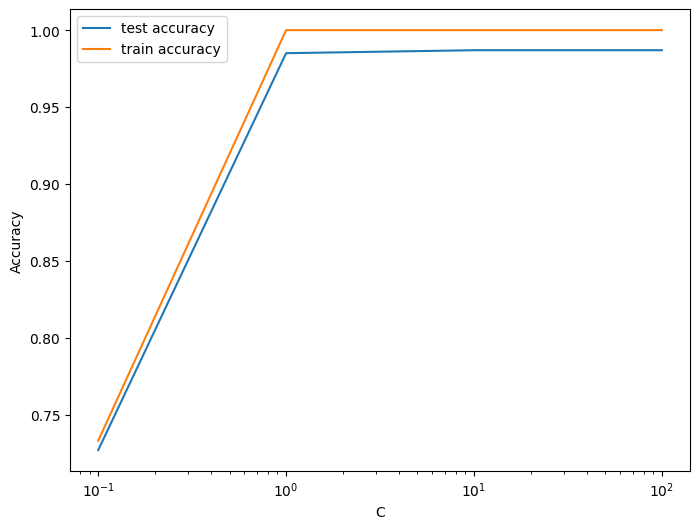

In [26]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.legend(['test accuracy', 'train accuracy'], loc='upper left')
plt.xscale('log')

In [27]:
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" Akurasi test tertinggi adalah {0} dengan C = {1}".format(best_score, best_C))

 Akurasi test tertinggi adalah 0.9869439625209564 dengan C = 10


# metrik yang berhubungan dengan C=10.

In [28]:
model = SVC(C=best_C)
model.fit(x_train_tfidf, y_train)
y_pred = model.predict(x_test_tfidf)

In [29]:
# metrics
print("accuracy", metrics.accuracy_score(y_test, y_pred))
print("precision", metrics.precision_score(y_test, y_pred))
print("recall", metrics.recall_score(y_test, y_pred))
print("F1-Score", metrics.f1_score(y_test, y_pred))

accuracy 0.9835748792270531
precision 0.9609120521172638
recall 0.9833333333333333
F1-Score 0.971993410214168


In [30]:
import pickle

# Membaca data dari file CSV
train_data = pd.read_csv('train_data_spam_ham.csv')
test_data = pd.read_csv('test_data_spam_ham.csv')

# Menyimpan DataFrame ke dalam file pickle
train_data.to_pickle('train_data_spam_ham.pkl')
test_data.to_pickle('test_data_spam_ham.pkl')

**Confusion Matrix**

# TUNING

# Tuning hyper-parameters for accuracy


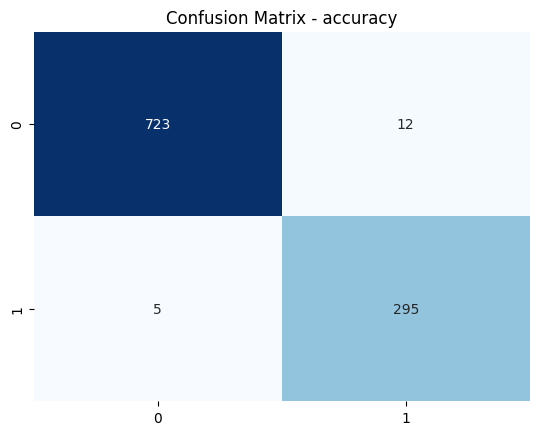

 accuracy Score is 0.9869439625209564 at C = {'C': 10}

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       735
           1       0.96      0.98      0.97       300

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



# Tuning hyper-parameters for precision


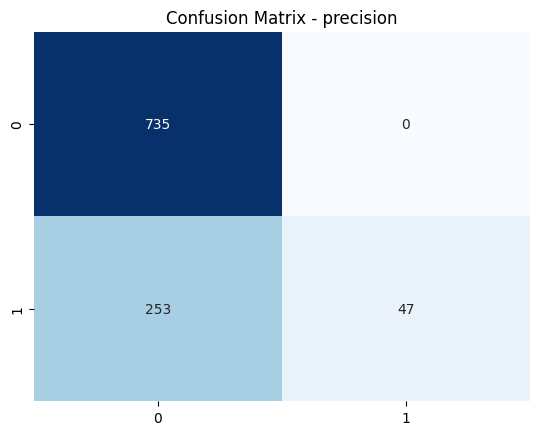

 precision Score is 1.0 at C = {'C': 0.1}

Classification Report:
              precision    recall  f1-score   support

           0       0.74      1.00      0.85       735
           1       1.00      0.16      0.27       300

    accuracy                           0.76      1035
   macro avg       0.87      0.58      0.56      1035
weighted avg       0.82      0.76      0.68      1035



# Tuning hyper-parameters for recall


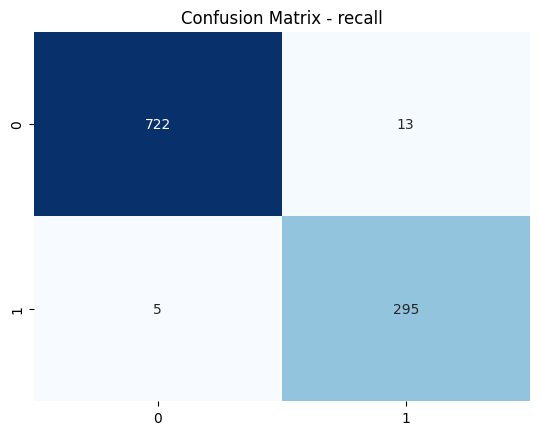

 recall Score is 0.99273706203793 at C = {'C': 1}

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       735
           1       0.96      0.98      0.97       300

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035



# Tuning hyper-parameters for f1


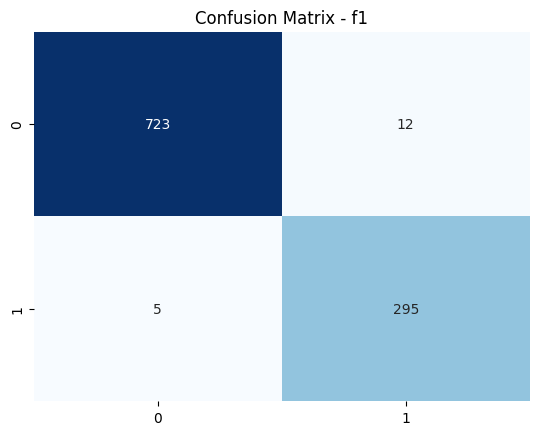

 f1 Score is 0.9775061931941366 at C = {'C': 10}

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.99       735
           1       0.96      0.98      0.97       300

    accuracy                           0.98      1035
   macro avg       0.98      0.98      0.98      1035
weighted avg       0.98      0.98      0.98      1035





In [43]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Specify parameters
params = {"C": [0.1, 1, 10, 100]}

# Specify scores/metrics in an iterable
scores = ['accuracy', 'precision', 'recall', 'f1']

for score in scores:
    print("# Tuning hyper-parameters for {}".format(score))

    # Set up GridSearch for score metric
    clf = GridSearchCV(SVC(),
                       params,
                       cv=folds,
                       scoring=score,
                       return_train_score=True)

    # Fit
    clf.fit(x_train_tfidf, y_train)

    # Predictions on the test set
    y_test_pred = clf.predict(x_test_tfidf)

    # Calculate confusion matrix
    conf_matrix = confusion_matrix(y_test, y_test_pred)

    # Display confusion matrix using seaborn heatmap
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {score}')
    plt.show()

    print(" {0} Score is {1} at C = {2}".format(score, clf.best_score_, clf.best_params_))
    print("\nClassification Report:")
    print(classification_report(y_test, y_test_pred))
    print("\n")
